In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight
from sklearn.cross_validation import train_test_split

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db
import warnings
warnings.filterwarnings('ignore')

In [6]:
ls /home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles

AF_L.trk             CCMid.trk  CST_R.trk   IFOF_L.trk
AF_R.trk             C_L.trk    F_L.trk     MCP.trk
CC_ForcepsMajor.trk  C_R.trk    F_R.trk     UF_L.trk
CC_ForcepsMinor.trk  CST_L.trk  IF0F_R.trk  UF_R.trk


In [7]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [8]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [9]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [10]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [11]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [12]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100
dil_iters = 5

In [13]:
%%time
import imp  
imp.reload(bn)
streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,dil_iters).compute() 
data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
CPU times: user 4.9 s, sys: 632 ms, total: 5.53 s
Wall time: 20.5 s


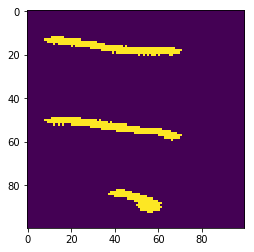

In [14]:
plt.imshow(streamlines_processed[5][1,:,:,0])

In [15]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels_train),
                                                 labels_train)

In [17]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test  = keras.utils.to_categorical(labels_test, num_classes)
labels_val  = keras.utils.to_categorical(labels_val, num_classes)

In [18]:
imp.reload(bn)
model = bn.buildmodel(input_shape,num_classes)

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list,
                     class_weight=class_weights)

Train on 921 samples, validate on 231 samples
Epoch 1/16
921/921 [==============================] - 19s 20ms/step - loss: 0.2710 - acc: 0.9197 - val_loss: 0.0018 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to checkpoints/weights.best.hdf5
Epoch 2/16
921/921 [==============================] - 18s 20ms/step - loss: 0.0092 - acc: 0.9978 - val_loss: 1.2706e-04 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/16
921/921 [==============================] - 18s 20ms/step - loss: 0.0694 - acc: 0.9826 - val_loss: 0.0014 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/16
921/921 [==============================] - 18s 20ms/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0068 - val_acc: 0.9957

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/16
921/921 [==============================] - 18s 20ms/step - loss: 0.0089 - acc: 0.9967 - val_loss: 1.8528e-05 - val_acc: 1.0000

Epoch 00005: val_acc di

In [22]:
model.load_weights("checkpoints/weights.best.hdf5")

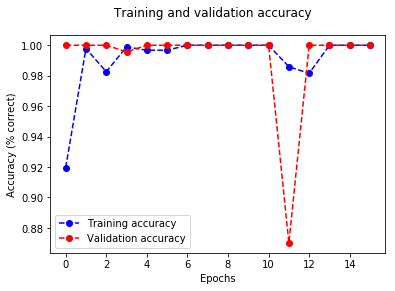

In [23]:
fig = bn.plot_accuracy(training)

In [24]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [25]:
imp.reload(bn)

<module 'bundlenet' from '/home/ubuntu/bundlenet/bundlenet.py'>

In [26]:
if op.exists('./streamlines_processed_100307.npz'):
    loaded_from_file = np.load('streamlines_processed_100307.npz')
    streamlines_all_processed_subj1 = loaded_from_file['processed_streamlines']
    labels_selected_s1 = loaded_from_file['streamline_labels']
else:
    streamlines_all_s1 = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
    map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
    labeled_index_s1, labels_s1 = bn.getlabeledstreamlines(map_files)
    unlabeled_index_s1 = bn.getunlabeledstreamlines(len(streamlines_all_s1), labeled_index_s1, len(streamlines_all_s1)-len(labeled_index_s1), 0)
    labels_selected_s1, streamlines_selected_s1 = bn.combinestreamlines(labeled_index_s1, unlabeled_index_s1, labels_s1, streamlines_all_s1)
    streamlines_all_processed_subj1 = bn.process_sl(streamlines_selected_s1,-1,vol_shape_subj2,size_slimage,dil_iters)
    np.savez('streamlines_processed_100307',processed_streamlines = streamlines_all_processed_subj1, streamline_labels = labels_selected_s1)

In [27]:
p_subj1 = model.predict(streamlines_all_processed_subj1, batch_size=5)
p_idx_s1 = np.argmax(p_subj1, axis=-1)

In [28]:
bn.print_accuarcystats(p_idx_s1[labels_selected_s1<16],labels_selected_s1[labels_selected_s1<16])

Percent correct is 0.9906597427944098 
Kappa is: 0.9886842515118464
Jaccard is: 0.9906597427944098


In [29]:
imp.reload(bn)
X_train, X_test, y_train, y_test = train_test_split(p_subj1,  labels_selected_s1, test_size=0.2, random_state=42, stratify=labels_selected_s1)
p = bn.run_xgboost(X_train,y_train,X_test,y_test,10,17)

In [31]:
p_idx_s1[labels_selected_s1==16]

array([1, 1, 1, ..., 5, 0, 5])

(array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  4.]),
 array([15.        , 15.05882353, 15.11764706, 15.17647059, 15.23529412,
        15.29411765, 15.35294118, 15.41176471, 15.47058824, 15.52941176,
        15.58823529, 15.64705882, 15.70588235, 15.76470588, 15.82352941,
        15.88235294, 15.94117647, 16.        ]),
 <a list of 17 Patch objects>)

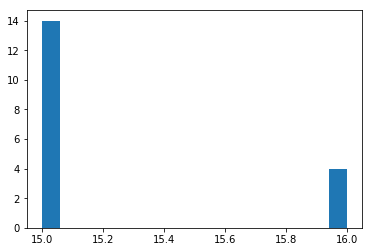

In [32]:
ind=y_test==15
plt.hist(p[ind],bins=17)

In [33]:
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = y_test == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p[ind]==i)/np.sum(ind)
perc_correct

array([[0.95737705],
       [0.91463415],
       [0.96175138],
       [0.96015936],
       [0.93091733],
       [0.98217822],
       [0.97186147],
       [0.796875  ],
       [0.90697674],
       [0.8       ],
       [0.74074074],
       [0.93181818],
       [0.94382022],
       [0.58285714],
       [1.        ],
       [0.77777778],
       [0.9907247 ]])

In [34]:
nsl

array([[3.0500e+02],
       [8.2000e+01],
       [1.9870e+03],
       [5.0200e+02],
       [8.8300e+02],
       [5.0500e+02],
       [4.6200e+02],
       [1.2800e+02],
       [1.2900e+02],
       [1.5000e+01],
       [2.7000e+01],
       [2.2000e+02],
       [2.6700e+02],
       [1.7500e+02],
       [3.4000e+01],
       [1.8000e+01],
       [3.5794e+04]])

In [35]:
if op.exists('./streamlines_processed_100408.npz'):
    loaded_from_file = np.load('streamlines_processed_100408.npz')
    streamlines_all_processed_subj2 = loaded_from_file['processed_streamlines']
    labels_selected_s2 = loaded_from_file['streamline_labels']
else:
    streamlines_all_s2 = bn.read_sl_mni('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
    map_files = sorted(glob('/home/ubuntu/recobundles/100408/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
    labeled_index_s2, labels_s2 = bn.getlabeledstreamlines(map_files)
    unlabeled_index_s2 = bn.getunlabeledstreamlines(len(streamlines_all_s2), labeled_index_s2, len(streamlines_all_s2)-len(labeled_index_s2), 0)
    labels_selected_s2, streamlines_selected_s2 = bn.combinestreamlines(labeled_index_s2, unlabeled_index_s2, labels_s2, streamlines_all_s2)
    streamlines_all_processed_subj2 = bn.process_sl(streamlines_selected_s2,-1,vol_shape_subj2,size_slimage,dil_iters)
    np.savez('streamlines_processed_100408',processed_streamlines = streamlines_all_processed_subj2, streamline_labels = labels_selected_s2)

In [ ]:
p_subj2 = model.predict(streamlines_all_processed_subj2, batch_size=5)
p_idx_s2 = np.argmax(p_subj2, axis=-1)

In [ ]:
bn.print_accuarcystats(p_idx_s2[labels_selected_s2<16],labels_selected_s2[labels_selected_s2<16])

In [ ]:
p_s2 = bn.run_xgboost(p_subj1,labels_selected_s1,p_subj2,labels_selected_s2,10,17)

In [ ]:
ind=labels_selected_s2==2
plt.hist(p_s2[ind],bins=17)

In [ ]:
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = labels_selected_s2 == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_s2[ind]==i)/np.sum(ind)
perc_correct

In [ ]:
p_subj2_withclass = model.predict(streamlines_all_processed_subj2[preds_max<16,:,:,:], batch_size=5)

In [ ]:
l = labels_subj2[preds_max<16]
p_withclass_2 = np.argmax(p_subj2_withclass,axis=1)
perc_correct = np.zeros((16,1))
nsl = np.zeros((16,1))
for i in range(16):
    ind = l == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_withclass_2[ind]==i)/np.sum(ind)
perc_correct

In [ ]:
imp.reload(bn)
streamlines_all2_nomni = bn.read_sl('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk')
streamlines_all_nomni_subj2 = [streamlines_all2_nomni[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]

In [ ]:
tmp = np.where(p<16)
t = tmp[0]
classified_streamlines = [streamlines_all_nomni_subj2[i] for i in t ]

In [ ]:
probs = np.max(p_subj2_nounclass,axis=1)

In [ ]:
bundle_names

In [ ]:
imp.reload(bn)
for i, bund in enumerate(bundle_names):
    bn.savesegtrk(classified_streamlines, p_withclass_2, i, probs, 0.9,'TRK/'+bund+'.trk',0)